# Comparing predictions from GSE and directly from molecular structure

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

### Predicting solubility using General Solubility Equation

The General Solubility Equation (GSE) is log S = 0.5 - (0.01 * melting point (in celsius) - 25) - log P

In [11]:
# loading aqsoldb as dataframe
df = pd.read_csv('curated_aqsoldb.csv')

In [12]:
def gse(df):
    log_S = 0.5 - 0.01 * (df['Melting Point'] - 25) - df['MolLogP']
    df['GSE LogS'] = log_S
    return df

df = df.apply(gse, axis=1)

[Text(0.5, 1.0, 'GSE for predicting solubility'),
 Text(0.5, 0, 'experimental LogS'),
 Text(0, 0.5, 'predicted LogS')]

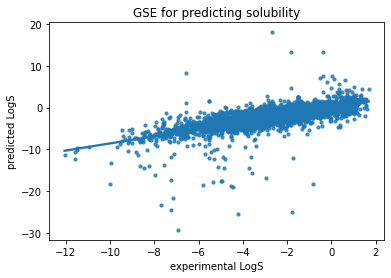

In [59]:
# plot results
sns.regplot(data=df, x='Solubility', y='GSE LogS', scatter_kws={"s": 10}).set(title='GSE for predicting solubility', xlabel='experimental LogS', ylabel='predicted LogS')

(-12.0, 2.0)

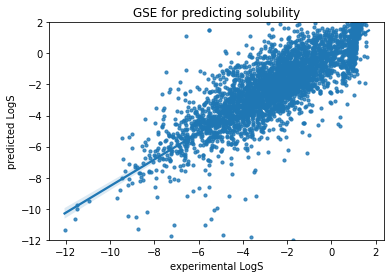

In [60]:
# plot results using same scale on both axis
sns.regplot(data=df, x='Solubility', y='GSE LogS', scatter_kws={"s": 10}).set(title='GSE for predicting solubility', xlabel='experimental LogS', ylabel='predicted LogS')
plt.ylim(-12, 2)

In [61]:
df_with_mp = df.dropna(subset=['Melting Point'])
r2_score(df_with_mp['Solubility'], df_with_mp['GSE LogS'])

0.2297247621584888

### Predicting solubility directly from molecular structure

##### Using descriptors based on Delaney's method - MolLogP, MolWt, NumRotatableBonds, AromaticProportion (AP) (https://pubmed.ncbi.nlm.nih.gov/15154768/)

Note: From my own EDA, I have found that MolLogP and MolWt have a much larger correlation to solubility that NumRotatableBonds and AromaticProportion

To keep the comparison fair we will need to use the same 3571 molecules used for the GSE prediction above.

In [24]:
df_with_mp = df.dropna(subset=['Melting Point'])

In [25]:
# creating X matrix from descriptors chosen
X = df_with_mp[['MolLogP', 'MolWt', 'NumRotatableBonds', 'AP']]
X

,MolLogP,MolWt,NumRotatableBonds,AP
1,2.40550,169.183,0.0,0.769231
2,2.15250,140.569,1.0,0.666667
5,2.63802,118.179,1.0,0.666667
8,3.19580,218.202,2.0,0.750000
10,1.56510,149.193,2.0,0.545455
...,...,...,...,...
10052,1.45900,314.411,10.0,0.238095
10055,1.47644,278.337,3.0,0.631579
10057,4.36550,356.418,4.0,0.480000
10060,2.82402,150.221,1.0,0.545455


In [26]:
# creating Y matrix from Solubility values
Y = df_with_mp['Solubility']

In [27]:
# split dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, Y)

#### Will be comparing to best perfoming model so random forest

In [38]:
from sklearn.ensemble import RandomForestRegressor

In [28]:
# build random forest regresson model
rf = RandomForestRegressor()

# fit model using training set
rf.fit(x_train, y_train)

RandomForestRegressor()

In [29]:
# solubility values predicted using test labels
rf_y_predict = rf.predict(x_test)

In [30]:
rf.score(x_test, y_test)

0.757371433654542

In [31]:
rf.score(x_train, y_train)

0.9656621651764258

[Text(0.5, 1.0, 'Solubility prediction using random forest regression'),
 Text(0.5, 0, 'experimental LogS'),
 Text(0, 0.5, 'predicted LogS')]

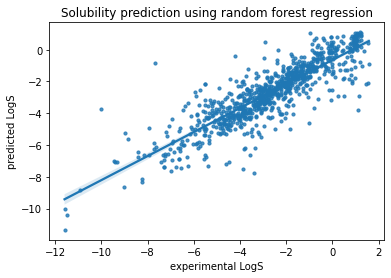

In [32]:
sns.regplot(x=y_test, y=rf_y_predict, scatter_kws={"s": 10}).set(title='Solubility prediction using random forest regression', xlabel='experimental LogS', ylabel='predicted LogS')

#### Now comparing against linear regression

In [39]:
from sklearn.linear_model import LinearRegression

In [40]:
# build linear regresson model
regr = LinearRegression()

# fit model using training set
regr.fit(x_train, y_train)

LinearRegression()

In [41]:
# intercept value
regr.intercept_

0.040301972920572915

In [42]:
# gradient value
regr.coef_

array([-0.51129942, -0.00803091,  0.07056353, -0.53409569])

In [43]:
# predict solubility values using the test set
regr_y_predict = regr.predict(x_test)

In [44]:
regr.score(x_train, y_train)

0.6120579031305171

In [45]:
regr.score(x_test, y_test)

0.597793647603805

In [48]:
mean_squared_error(y_test, regr_y_predict)

# shows there is a high measure of error

2.0710246638154515

In [49]:
r2_score(y_test, regr_y_predict)

# shows poor goodness of fit

0.597793647603805

[Text(0.5, 1.0, 'Multiple linear regression for predicting solubility'),
 Text(0.5, 0, 'experimental solubility values'),
 Text(0, 0.5, 'predicted solubility values')]

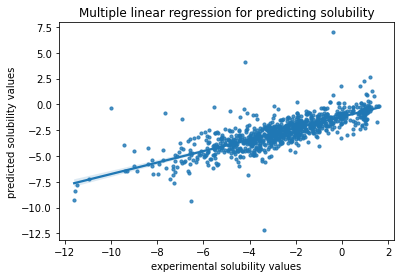

In [54]:
sns.regplot(x=y_test, y=regr_y_predict, scatter_kws={"s": 10}).set(title='Multiple linear regression for predicting solubility', xlabel='experimental solubility values', ylabel='predicted solubility values')
# plt.ylim(-12, 2)
# plt.savefig('mlr_delaney.jpg', bbox_inches='tight')